# Problem Statement: **AtliQ's Customer Churn Prediction**

### Welcome to AtliQ Electronics, a leading consumer electronics retailer! AtliQ has been facing customer churn issues and is building an AI-powered predictive model to identify customers likely to discontinue their services. However, the data science team observed that the model tends to overfit the training data, leading to poor generalization on new data. Your task is to implement and compare different regularization techniques to build a robust and accurate churn prediction model.


**References**

* Batchnorm1d (PyTorch): [Link](https://pytorch.org/docs/stable/generated/torch.nn.BatchNorm1d.html)


Imports and CUDA

In [32]:
import torch
import numpy as np
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler

# Check if CUDA (GPU) is available
device = torch.device('cuda' if torch.cuda.is_available() else 'mps')
print(f"Using device: {device}")

Using device: mps


### Let's do some revisoin first and test your basic understanding of this module!

Problem1: **Effect of L1 Regularization on Sparsity in AtliQ's AI Models**

AtliQ is optimizing its AI models to reduce unnecessary complexity. You are given the following weights from one of AtliQ's neural network layers:



```
weights = torch.tensor([0.5, -0.3, 0.8, -1.5], requires_grad=True)
```

Write a PyTorch snippet to compute the L1 regularization term ``` (|w1| + |w2| + ...) ``` and calculate its gradient using backward().


In [33]:
# weights
weights = torch.tensor([0.5, -0.3, 0.8, -1.5], requires_grad=True)

# Compute L1 regularization term
l1_regularization = torch.sum(torch.abs(weights))

# compute gradients
l1_regularization.backward()

# Output gradients
print(f"L1 Regularization: {l1_regularization.item():.4f}")
print(f"Gradients: {weights.grad}")

L1 Regularization: 3.1000
Gradients: tensor([ 1., -1.,  1., -1.])




---



Problem2: **Batch Normalization of AtliQ's Marketing Data**

AtliQ has collected a mini-batch of marketing data:

`inputs = torch.tensor([[10.0, 20.0], [15.0, 25.0], [12.0, 18.0]])`

Manually implement the forward pass of Batch Normalization. Normalize the data using:

$$Normalized= X-μ / σ$$

Here, μ is the mean of each feature, and σ is the standard deviation.

Write code to compute the normalized data without using `nn.BatchNorm`.





In [34]:
# inputs
inputs = torch.tensor([[10.0, 20.0], [15.0, 25.0], [12.0, 18.0]])

# compute mean and standard deviation along each column (feature)
mean = inputs.mean(dim=0)
std = inputs.std(dim=0)

# normalize the input
normalized = (inputs - mean) / std

print(f"Inputs:\n{inputs}")
print(f"Mean: {mean}")
print(f"Standard Deviation: {std}")
print(f"Normalized Outputs:\n{normalized}")

Inputs:
tensor([[10., 20.],
        [15., 25.],
        [12., 18.]])
Mean: tensor([12.3333, 21.0000])
Standard Deviation: tensor([2.5166, 3.6056])
Normalized Outputs:
tensor([[-0.9272, -0.2774],
        [ 1.0596,  1.1094],
        [-0.1325, -0.8321]])




---



### Task: **AtliQ's Customer Churn Prediction**



**Dataset Description**

You are provided with 5000 customer records and 6 features that describe customer behavior over the past 12 months. The provided dataset (**AtliQ_Churn_Prediction_Codebasics_DL.csv)** includes the following attributes:

* Purchase_History
* Support_Tickets
* Last_Purchase_Months
* Product_Categories
* Satisfaction_Score
* Discount_Usage_Rate

Target Variable:

* Churned: 1 if the customer has churned, 0 otherwise.

**Step1**: Load and Prepare the Dataset

In [35]:
# Load dataset
data = pd.read_csv('AtliQ_Churn_Prediction_Codebasics_DL.csv')

# Separate features and target
X = data.drop("Churned", axis=1).values
y = data['Churned'].values

data.describe()

,Purchase_History,Support_Tickets,Last_Purchase_Months,Product_Categories,Satisfaction_Score,Discount_Usage_Rate,Churned
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000
mean,25.232400,9.660800,11.698200,4.941400,5.450108,0.501942,0.304000
std,14.138004,5.726526,6.904162,2.581879,2.584613,0.288965,0.460029
min,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000
25%,13.000000,5.000000,6.000000,3.000000,3.200000,0.250000,0.000000
50%,25.000000,10.000000,12.000000,5.000000,5.420000,0.500000,0.000000
75%,37.000000,15.000000,18.000000,7.000000,7.650000,0.750000,1.000000
max,49.000000,19.000000,23.000000,9.000000,10.000000,1.000000,1.000000




---



**Step2**: Split the Dataset

Train : Test :: 70 : 30



---



In [36]:
# Split data

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)




---



**Step3**: Normalize the features



In [37]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)



---



**Step4**: Convert to PyTorch Tensors

In [38]:
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)
y_train_tensor

tensor([[1.],
        [1.],
        [0.],
        ...,
        [1.],
        [1.],
        [0.]])



---



**Step5**: Build a Base Model (without regularization)

Details:
* Input layer: 6 features
* Hidden layers: Two layers with 32 and 16 neurons (ReLU activation)
* Output layer: 1 neuron (Sigmoid activation for binary classification)
* Train for 30 epochs, batch size = 32, learning rate = 0.01.
* Use **BCELoss** and **SGD** as Optimizer

In [39]:
class BaseModel(nn.Module):
    def __init__(self):
        super(BaseModel, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(6, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.network(x)

model = BaseModel()
loss_function = nn.BCELoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)




---



**Step6**: Train the Base Model

* epochs = 30
* batch size = 32

Epoch 1, Training Loss: 0.6551, Validation Loss: 0.6366
Epoch 2, Training Loss: 0.6315, Validation Loss: 0.6216
Epoch 3, Training Loss: 0.6220, Validation Loss: 0.6154
Epoch 4, Training Loss: 0.6181, Validation Loss: 0.6130
Epoch 5, Training Loss: 0.6166, Validation Loss: 0.6120
Epoch 6, Training Loss: 0.6159, Validation Loss: 0.6115
Epoch 7, Training Loss: 0.6156, Validation Loss: 0.6113
Epoch 8, Training Loss: 0.6154, Validation Loss: 0.6112
Epoch 9, Training Loss: 0.6152, Validation Loss: 0.6111
Epoch 10, Training Loss: 0.6151, Validation Loss: 0.6110
Epoch 11, Training Loss: 0.6149, Validation Loss: 0.6109
Epoch 12, Training Loss: 0.6148, Validation Loss: 0.6109
Epoch 13, Training Loss: 0.6147, Validation Loss: 0.6108
Epoch 14, Training Loss: 0.6146, Validation Loss: 0.6108
Epoch 15, Training Loss: 0.6145, Validation Loss: 0.6108
Epoch 16, Training Loss: 0.6143, Validation Loss: 0.6108
Epoch 17, Training Loss: 0.6142, Validation Loss: 0.6107
Epoch 18, Training Loss: 0.6141, Validat

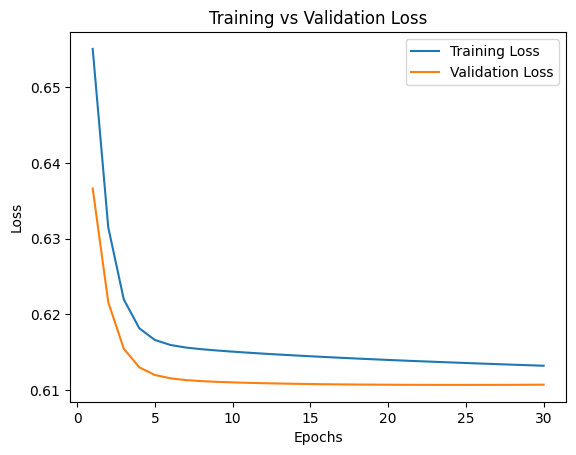

In [40]:
# Train the model
epochs = 30
batch_size = 32
num_batches = len(X_train_tensor) // batch_size

train_loss_history = []
val_loss_history = []

for epoch in range(epochs):
    model.train()
    epoch_loss = 0

    for i in range(num_batches):
        X_batch = X_train_tensor[i*batch_size:(i+1)*batch_size]
        
        y_batch = y_train_tensor[i*batch_size:(i+1)*batch_size]
        
        optimizer.zero_grad()
        y_pred = model(X_batch)
        loss = loss_function(y_pred, y_batch)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    train_loss_history.append(epoch_loss / num_batches)

    # Validation loss
    model.eval()
    with torch.no_grad():
        val_predictions = model(X_test_tensor)
        val_loss = loss_function(val_predictions, y_test_tensor)
        val_loss_history.append(val_loss.item())

    print(f"Epoch {epoch+1}, Training Loss: {epoch_loss/num_batches:.4f}, Validation Loss: {val_loss.item():.4f}")

# Plot training vs validation loss
plt.plot(range(1, epochs+1), train_loss_history, label="Training Loss")
plt.plot(range(1, epochs+1), val_loss_history, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Training vs Validation Loss")
plt.show()



---



**Step7**: Implement Dropout Regularization

Modify the base model to include dropout layers after each dense layer.
* Experiment with dropout rate 0.4.

In [47]:
class DropoutModel(nn.Module):
    def __init__(self):
        super(DropoutModel, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(6, 32),
            nn.ReLU(),
            nn.Dropout(p=0.4),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Dropout(p=0.4),
            nn.Linear(16, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.network(x)

dropout_model = DropoutModel()
optimizer_dropout = optim.SGD(dropout_model.parameters(), lr=0.01)




---



**Step8**: Training Process for Dropout Regularization

Epoch 1, Training Loss: 0.6614, Validation Loss: 0.6443
Epoch 2, Training Loss: 0.6368, Validation Loss: 0.6280
Epoch 3, Training Loss: 0.6271, Validation Loss: 0.6208
Epoch 4, Training Loss: 0.6221, Validation Loss: 0.6173
Epoch 5, Training Loss: 0.6203, Validation Loss: 0.6156
Epoch 6, Training Loss: 0.6174, Validation Loss: 0.6147
Epoch 7, Training Loss: 0.6184, Validation Loss: 0.6141
Epoch 8, Training Loss: 0.6162, Validation Loss: 0.6138
Epoch 9, Training Loss: 0.6178, Validation Loss: 0.6135
Epoch 10, Training Loss: 0.6171, Validation Loss: 0.6133
Epoch 11, Training Loss: 0.6152, Validation Loss: 0.6132
Epoch 12, Training Loss: 0.6174, Validation Loss: 0.6131
Epoch 13, Training Loss: 0.6177, Validation Loss: 0.6130
Epoch 14, Training Loss: 0.6161, Validation Loss: 0.6130
Epoch 15, Training Loss: 0.6157, Validation Loss: 0.6129
Epoch 16, Training Loss: 0.6151, Validation Loss: 0.6129
Epoch 17, Training Loss: 0.6153, Validation Loss: 0.6128
Epoch 18, Training Loss: 0.6152, Validat

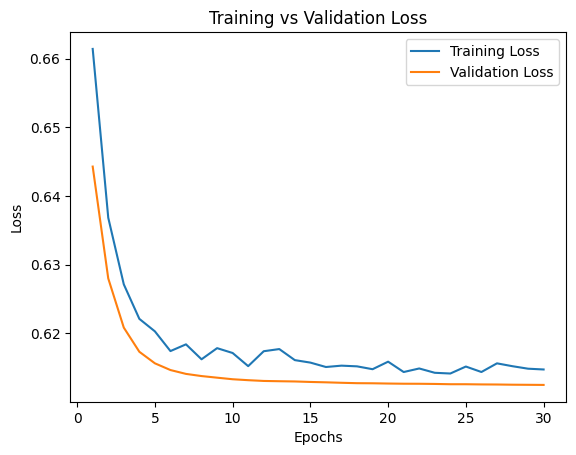

In [48]:
# Train the model for Dropout Regularization (Similar training process as above)
epochs = 30
batch_size = 32
num_batches = len(X_train_tensor) // batch_size

train_loss_history = []
val_loss_history = []

for epoch in range(epochs):
    dropout_model.train()
    epoch_loss = 0

    for i in range(num_batches):
        X_batch = X_train_tensor[i*batch_size:(i+1)*batch_size]
        y_batch = y_train_tensor[i*batch_size:(i+1)*batch_size]
        

        optimizer_dropout.zero_grad()
        y_pred = dropout_model(X_batch)
        loss = loss_function(y_pred, y_batch)
        loss.backward()
        optimizer_dropout.step()
        epoch_loss += loss.item()

    train_loss_history.append(epoch_loss / num_batches)

    # Validation loss
    dropout_model.eval()
    with torch.no_grad():
        val_predictions = dropout_model(X_test_tensor)
        val_loss = loss_function(val_predictions, y_test_tensor)
        val_loss_history.append(val_loss.item())

    print(f"Epoch {epoch+1}, Training Loss: {epoch_loss/num_batches:.4f}, Validation Loss: {val_loss.item():.4f}")

# Plot training vs validation loss
plt.plot(range(1, epochs+1), train_loss_history, label="Training Loss")
plt.plot(range(1, epochs+1), val_loss_history, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Training vs Validation Loss")
plt.show()



---



**Step9**: Apply L2 Regularization

* Use `torch.optim.SGD` with `weight_decay=0.1` for L2 regularization.
* Train the model and monitor validation loss and accuracy.

Epoch 1, Training Loss: 0.6137, Validation Loss: 0.6123
Epoch 2, Training Loss: 0.6155, Validation Loss: 0.6141
Epoch 3, Training Loss: 0.6171, Validation Loss: 0.6157
Epoch 4, Training Loss: 0.6184, Validation Loss: 0.6168
Epoch 5, Training Loss: 0.6194, Validation Loss: 0.6176
Epoch 6, Training Loss: 0.6201, Validation Loss: 0.6182
Epoch 7, Training Loss: 0.6207, Validation Loss: 0.6187
Epoch 8, Training Loss: 0.6211, Validation Loss: 0.6190
Epoch 9, Training Loss: 0.6213, Validation Loss: 0.6192
Epoch 10, Training Loss: 0.6215, Validation Loss: 0.6194
Epoch 11, Training Loss: 0.6217, Validation Loss: 0.6195
Epoch 12, Training Loss: 0.6218, Validation Loss: 0.6195
Epoch 13, Training Loss: 0.6218, Validation Loss: 0.6196
Epoch 14, Training Loss: 0.6219, Validation Loss: 0.6196
Epoch 15, Training Loss: 0.6219, Validation Loss: 0.6196
Epoch 16, Training Loss: 0.6219, Validation Loss: 0.6196
Epoch 17, Training Loss: 0.6220, Validation Loss: 0.6196
Epoch 18, Training Loss: 0.6220, Validat

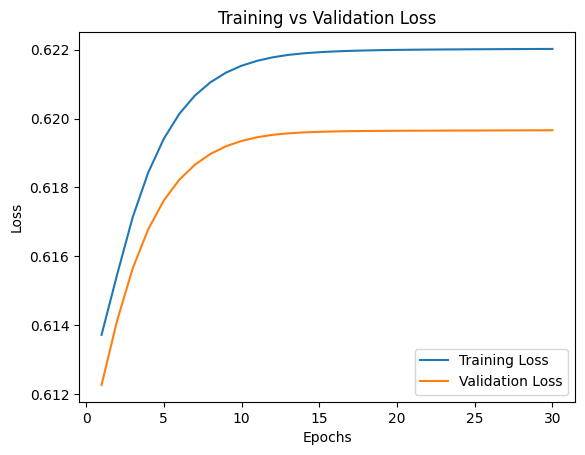

In [49]:
# L2 regularization (weight decay)
optimizer_l2 = optim.SGD(model.parameters(), lr=0.01, weight_decay=0.1)

# Train the model for L2 Regularization (Similar training process as above)
epochs = 30
batch_size = 32
num_batches = len(X_train_tensor) // batch_size

train_loss_history = []
val_loss_history = []

for epoch in range(epochs):
    model.train() # model will remain the same
    epoch_loss = 0

    for i in range(num_batches):
        X_batch = X_train_tensor[i*batch_size:(i+1)*batch_size]
        y_batch = y_train_tensor[i*batch_size:(i+1)*batch_size]

        optimizer_l2.zero_grad()
        y_pred = model(X_batch)
        loss = loss_function(y_pred, y_batch)
        loss.backward()
        optimizer_l2.step()
        epoch_loss += loss.item()

    train_loss_history.append(epoch_loss / num_batches)

    # Validation loss
    model.eval()
    with torch.no_grad():
        val_predictions = model(X_test_tensor)
        val_loss = loss_function(val_predictions, y_test_tensor)
        val_loss_history.append(val_loss.item())

    print(f"Epoch {epoch+1}, Training Loss: {epoch_loss/num_batches:.4f}, Validation Loss: {val_loss.item():.4f}")

# Plot training vs validation loss
plt.plot(range(1, epochs+1), train_loss_history, label="Training Loss")
plt.plot(range(1, epochs+1), val_loss_history, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Training vs Validation Loss")
plt.show()


**Key Insights**:

The L2 regularization plot shows concerning behavior where both training and validation losses are increasing over time, indicating the model is diverging from the optimal solution rather than converging to it. This divergent behavior suggests the L2 regularization strength (weight decay) might be too aggressive, penalizing the weights too heavily and preventing the model from finding the optimal minimum.



---



**Step10**: Add Batch Normalization

* use BatchNorm1d
* use **SGD** Optimizer with learning rate = 0.01

In [54]:
class BatchNormModel(nn.Module):
    def __init__(self):
        super(BatchNormModel, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(6, 32),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.BatchNorm1d(16),
            nn.ReLU(),
            nn.Linear(16, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.layers(x)

# Train the BatchNormModel
batchnorm_model = BatchNormModel()
optimizer_bn = optim.SGD(batchnorm_model.parameters(), lr=0.01)




---



**Step11**: Training Process for Batch Normalization

Epoch 1, Training Loss: 0.6444, Validation Loss: 0.6243
Epoch 2, Training Loss: 0.6215, Validation Loss: 0.6166
Epoch 3, Training Loss: 0.6171, Validation Loss: 0.6149
Epoch 4, Training Loss: 0.6152, Validation Loss: 0.6143
Epoch 5, Training Loss: 0.6139, Validation Loss: 0.6139
Epoch 6, Training Loss: 0.6128, Validation Loss: 0.6136
Epoch 7, Training Loss: 0.6119, Validation Loss: 0.6135
Epoch 8, Training Loss: 0.6112, Validation Loss: 0.6134
Epoch 9, Training Loss: 0.6106, Validation Loss: 0.6133
Epoch 10, Training Loss: 0.6101, Validation Loss: 0.6133
Epoch 11, Training Loss: 0.6096, Validation Loss: 0.6134
Epoch 12, Training Loss: 0.6091, Validation Loss: 0.6135
Epoch 13, Training Loss: 0.6086, Validation Loss: 0.6136
Epoch 14, Training Loss: 0.6081, Validation Loss: 0.6136
Epoch 15, Training Loss: 0.6077, Validation Loss: 0.6137
Epoch 16, Training Loss: 0.6074, Validation Loss: 0.6138
Epoch 17, Training Loss: 0.6070, Validation Loss: 0.6139
Epoch 18, Training Loss: 0.6066, Validat

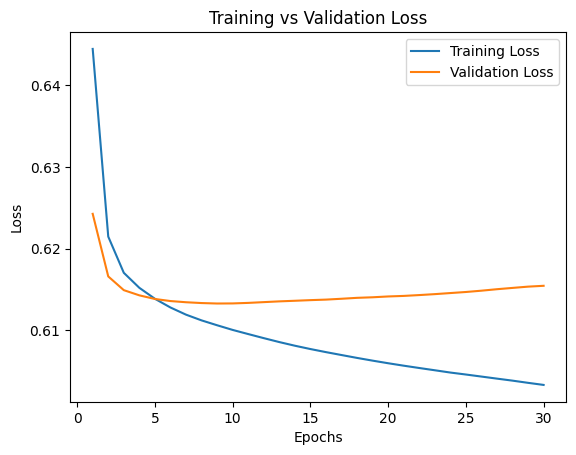

In [55]:
# Train the model for Batch Normalization (Similar training process as above)
epochs = 30
batch_size = 32
num_batches = len(X_train_tensor) // batch_size

train_loss_history = []
val_loss_history = []

for epoch in range(epochs):
    batchnorm_model.train()
    epoch_loss = 0

    for i in range(num_batches):
        X_batch = X_train_tensor[i*batch_size:(i+1)*batch_size]
        y_batch = y_train_tensor[i*batch_size:(i+1)*batch_size]

        
        optimizer_bn.zero_grad()
        y_pred = batchnorm_model(X_batch)
        loss = loss_function(y_pred, y_batch)
        loss.backward()
        optimizer_bn.step()
        epoch_loss += loss.item()

    train_loss_history.append(epoch_loss / num_batches)

    # Validation loss
    batchnorm_model.eval()
    with torch.no_grad():
        val_predictions = batchnorm_model(X_test_tensor)
        val_loss = loss_function(val_predictions, y_test_tensor)
        val_loss_history.append(val_loss.item())

    print(f"Epoch {epoch+1}, Training Loss: {epoch_loss/num_batches:.4f}, Validation Loss: {val_loss.item():.4f}")

# Plot training vs validation loss
plt.plot(range(1, epochs+1), train_loss_history, label="Training Loss")
plt.plot(range(1, epochs+1), val_loss_history, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Training vs Validation Loss")
plt.show()


**Key Insights**:

After an initial sharp decline in both losses, we observe a clear sign of overfitting where the training loss (blue) continues to decrease while validation loss (orange) starts to plateau and slightly increase after epoch 15.



---

